<a href="https://colab.research.google.com/github/ellencarols/Projeto-PIMG-ArUco/blob/main/C%C3%B3pia_de_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt

DETECÇÃO E ROTAÇÃO

Detecta região preta do ArUco

In [181]:
def detect_black_region_boundaries(gray_array):
    black_threshold = 80
    black_mask = (gray_array < black_threshold).astype(np.uint8) * 255
    return black_mask

Detecta bordas com Sobel

In [182]:
def sobel_edge_detection(gray_array):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

    height, width = gray_array.shape
    grad_x = np.zeros_like(gray_array, dtype=np.float32)
    grad_y = np.zeros_like(gray_array, dtype=np.float32)

    padded = np.pad(gray_array, ((1, 1), (1, 1)), mode='edge')

    for i in range(height):
        for j in range(width):
            region = padded[i:i+3, j:j+3].astype(np.float32)
            grad_x[i, j] = np.sum(region * sobel_x)
            grad_y[i, j] = np.sum(region * sobel_y)

    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    magnitude = np.clip(magnitude, 0, 255).astype(np.uint8)

    return magnitude, None

Transformada de Hough

In [183]:
def hough_transform_lines(edge_image, threshold=20):
    height, width = edge_image.shape
    diagonal = int(np.sqrt(height**2 + width**2))

    num_thetas = 180
    num_rhos = 2 * diagonal

    accumulator = np.zeros((num_rhos, num_thetas), dtype=np.uint32)

    thetas = np.deg2rad(np.arange(0, 180, 1))
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)

    edge_points = np.argwhere(edge_image > 100)

    for y, x in edge_points:
        for theta_idx in range(num_thetas):
            rho = int(x * cos_thetas[theta_idx] + y * sin_thetas[theta_idx])
            rho_idx = rho + diagonal
            if 0 <= rho_idx < num_rhos:
                accumulator[rho_idx, theta_idx] += 1

    lines = []
    acc_copy = accumulator.copy()

    for _ in range(20):
        max_val = np.max(acc_copy)
        if max_val < threshold:
            break

        max_idx = np.unravel_index(np.argmax(acc_copy), acc_copy.shape)
        rho_idx, theta_idx = max_idx

        rho = rho_idx - diagonal
        theta = thetas[theta_idx]

        lines.append((rho, theta, max_val))

        rho_min = max(0, rho_idx - 10)
        rho_max = min(num_rhos, rho_idx + 10)
        theta_min = max(0, theta_idx - 10)
        theta_max = min(num_thetas, theta_idx + 10)

        acc_copy[rho_min:rho_max, theta_min:theta_max] = 0

    return lines

Filtra linhas principais

In [184]:
def filter_main_lines(lines):
    horizontal_lines = []
    vertical_lines = []

    for rho, theta, votes in lines:
        theta_deg = np.rad2deg(theta)

        if theta_deg < 20 or theta_deg > 160:
            horizontal_lines.append((rho, theta, votes))
        elif 70 < theta_deg < 110:
            vertical_lines.append((rho, theta, votes))

    horizontal_lines.sort(key=lambda x: x[2], reverse=True)
    vertical_lines.sort(key=lambda x: x[2], reverse=True)

    return horizontal_lines[:2], vertical_lines[:2]

Calcula interseção

In [185]:
def line_intersection(line1, line2):
    rho1, theta1 = line1[0], line1[1]
    rho2, theta2 = line2[0], line2[1]

    a1, b1, c1 = np.cos(theta1), np.sin(theta1), rho1
    a2, b2, c2 = np.cos(theta2), np.sin(theta2), rho2

    det = a1 * b2 - a2 * b1

    if abs(det) < 1e-6:
        return None

    x = (b2 * c1 - b1 * c2) / det
    y = (a1 * c2 - a2 * c1) / det

    return (int(x), int(y))

Encontra cantos

In [186]:
def find_aruco_corners(h_lines, v_lines):
    if len(h_lines) < 2 or len(v_lines) < 2:
        return None

    corners = []

    for h_line in h_lines:
        for v_line in v_lines:
            intersection = line_intersection(h_line, v_line)
            if intersection is not None:
                corners.append(intersection)

    if len(corners) < 4:
        return None

    corners = np.array(corners)
    corners = corners[corners[:, 1].argsort()]

    top_corners = corners[:2]
    bottom_corners = corners[2:4]

    top_corners = top_corners[top_corners[:, 0].argsort()]
    bottom_corners = bottom_corners[bottom_corners[:, 0].argsort()]

    return np.vstack([top_corners[0], top_corners[1],
                      bottom_corners[1], bottom_corners[0]])

    Detecta onde está o texto em relação ao ArUco
    Retorna: 'above', 'below', 'left', 'right', ou None

In [187]:
def detect_text_position(gray_array, corners, debug=False):

    if corners is None:
        return None

    height, width = gray_array.shape

    # Centro do ArUco
    center_x = int(np.mean(corners[:, 0]))
    center_y = int(np.mean(corners[:, 1]))

    # Dimensões do ArUco
    aruco_width = int(np.max(corners[:, 0]) - np.min(corners[:, 0]))
    aruco_height = int(np.max(corners[:, 1]) - np.min(corners[:, 1]))

    # Threshold para detectar texto (pixels escuros)
    text_threshold = 180

    # Definir regiões para buscar texto
    margin = 20

    # Região ACIMA do ArUco
    y_above_start = max(0, int(np.min(corners[:, 1])) - aruco_height - margin)
    y_above_end = max(0, int(np.min(corners[:, 1])) - margin)
    region_above = gray_array[y_above_start:y_above_end, :]

    # Região ABAIXO do ArUco
    y_below_start = min(height, int(np.max(corners[:, 1])) + margin)
    y_below_end = min(height, int(np.max(corners[:, 1])) + aruco_height + margin)
    region_below = gray_array[y_below_start:y_below_end, :]

    # Região À ESQUERDA do ArUco
    x_left_start = max(0, int(np.min(corners[:, 0])) - aruco_width - margin)
    x_left_end = max(0, int(np.min(corners[:, 0])) - margin)
    region_left = gray_array[:, x_left_start:x_left_end]

    # Região À DIREITA do ArUco
    x_right_start = min(width, int(np.max(corners[:, 0])) + margin)
    x_right_end = min(width, int(np.max(corners[:, 0])) + aruco_width + margin)
    region_right = gray_array[:, x_right_start:x_right_end]

    def count_text_pixels(region):
        if region.size == 0:
            return 0
        return np.sum(region < text_threshold)

    text_above = count_text_pixels(region_above)
    text_below = count_text_pixels(region_below)
    text_left = count_text_pixels(region_left)
    text_right = count_text_pixels(region_right)

    if debug:
        print(f"   Texto detectado:")
        print(f"     Acima: {text_above} pixels")
        print(f"     Abaixo: {text_below} pixels")
        print(f"     Esquerda: {text_left} pixels")
        print(f"     Direita: {text_right} pixels")

    # Determinar posição dominante do texto
    max_text = max(text_above, text_below, text_left, text_right)

    if max_text < 100:
        if debug:
            print(f"   Texto insuficiente detectado")
        return None

    if text_above == max_text:
        return 'above'
    elif text_below == max_text:
        return 'below'
    elif text_left == max_text:
        return 'left'
    elif text_right == max_text:
        return 'right'

    return None

    Calcula rotação necessária baseado na posição do texto
    REGRA: Texto deve ficar ABAIXO do ArUco

In [188]:
def calculate_rotation_from_text_position(text_pos, debug=False):
    if text_pos is None:
        if debug:
            print("   ⚠ Texto não detectado, sem rotação")
        return 0

    if debug:
        print(f"   Texto detectado: {text_pos}")

    # Mapear posição do texto para rotação necessária
    rotation_map = {
        'below': 0,      # Texto abaixo = CORRETO, sem rotação
        'above': 180,    # Texto acima = inverter 180°
        'left': -90,     # Texto à esquerda = rotacionar 90° horário
        'right': 90,     # Texto à direita = rotacionar 90° anti-horário
    }

    rotation = rotation_map.get(text_pos, 0)

    if debug:
        if rotation == 0:
            print(f"   ✓ Texto já está ABAIXO (correto), rotação: 0°")
        else:
            print(f"   → Rotação necessária: {rotation}°")

    return rotation

Rotaciona Imagem

In [189]:
def rotate_image(img_array, angle_deg):
    if abs(angle_deg) < 0.5:
        return img_array

    height, width = img_array.shape[:2]
    center_x, center_y = width // 2, height // 2

    angle_rad = np.deg2rad(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)

    if len(img_array.shape) == 3:
        rotated = np.ones_like(img_array) * 255
    else:
        rotated = np.ones_like(img_array) * 255

    for y in range(height):
        for x in range(width):
            rel_x = x - center_x
            rel_y = y - center_y

            src_x = int(rel_x * cos_a + rel_y * sin_a + center_x)
            src_y = int(-rel_x * sin_a + rel_y * cos_a + center_y)

            if 0 <= src_x < width and 0 <= src_y < height:
                rotated[y, x] = img_array[src_y, src_x]

    return rotated


REMOÇÃO DE TEXTO

Detecta região do ArUco para preservação

In [190]:
def detect_aruco_region(gray_array):
    height, width = gray_array.shape

    threshold = 150
    binary = (gray_array < threshold).astype(np.uint8)

    col_sums = np.sum(binary, axis=0)
    row_sums = np.sum(binary, axis=1)

    col_threshold = height * 0.05
    row_threshold = width * 0.05

    significant_cols = np.where(col_sums > col_threshold)[0]
    significant_rows = np.where(row_sums > row_threshold)[0]

    if len(significant_cols) == 0 or len(significant_rows) == 0:
        margin = min(width, height) // 4
        return (width//2 - margin, height//2 - margin,
                width//2 + margin, height//2 + margin)

    col_groups = []
    current_group = [significant_cols[0]]
    for i in range(1, len(significant_cols)):
        if significant_cols[i] - significant_cols[i-1] <= 5:
            current_group.append(significant_cols[i])
        else:
            col_groups.append(current_group)
            current_group = [significant_cols[i]]
    col_groups.append(current_group)

    largest_col_group = max(col_groups, key=len)
    x_min = max(0, largest_col_group[0] - 10)
    x_max = min(width, largest_col_group[-1] + 10)

    row_groups = []
    current_group = [significant_rows[0]]
    for i in range(1, len(significant_rows)):
        if significant_rows[i] - significant_rows[i-1] <= 5:
            current_group.append(significant_rows[i])
        else:
            row_groups.append(current_group)
            current_group = [significant_rows[i]]
    row_groups.append(current_group)

    largest_row_group = max(row_groups, key=len)
    y_min = max(0, largest_row_group[0] - 10)
    y_max = min(height, largest_row_group[-1] + 10)

    return (x_min, y_min, x_max, y_max)

Remove texto, preserva ArUco

In [191]:
def remove_text_preserve_aruco(img_array):
    height, width = img_array.shape[0], img_array.shape[1]

    gray = np.dot(img_array[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)

    aruco_x_min, aruco_y_min, aruco_x_max, aruco_y_max = detect_aruco_region(gray)

    result = np.ones_like(img_array) * 255

    result[aruco_y_min:aruco_y_max, aruco_x_min:aruco_x_max] = \
        img_array[aruco_y_min:aruco_y_max, aruco_x_min:aruco_x_max]

    return result

PIPELINE COMPLETO

Pipeline completo com validação: TEXTO ABAIXO = CORRETO

In [192]:
def process_aruco_complete(input_path, output_rotated=None, output_final=None, debug=True):
    """
    Pipeline completo com validação: TEXTO ABAIXO = CORRETO
    """
    if debug:
        print("=" * 75)
        print("PIPELINE COMPLETO: ROTAÇÃO + REMOÇÃO DE TEXTO")
        print("REGRA: Texto ABAIXO do ArUco = CORRETO")
        print("=" * 75)
        print()

    # ==== ETAPA 1: ROTAÇÃO ====
    if debug:
        print("=" * 75)
        print("ETAPA 1: DETECTAR ORIENTAÇÃO E ROTACIONAR")
        print("=" * 75)
        print()

    # Carregar imagem
    if debug:
        print("→ Carregando imagem...")
    img_array = iio.imread(input_path)

    if len(img_array.shape) == 2:
        img_array = np.stack([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]

    if debug:
        print(f"  Dimensões: {img_array.shape[1]}x{img_array.shape[0]}px")
        print()

    # Converter para cinza
    if debug:
        print("→ Convertendo para escala de cinza...")
    gray = np.dot(img_array[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)
    print()

    # Detectar região preta
    if debug:
        print("→ Detectando região preta do ArUco...")
    black_mask = detect_black_region_boundaries(gray)
    print()

    # Detectar bordas
    if debug:
        print("→ Detectando bordas...")
    edges, _ = sobel_edge_detection(black_mask)
    print()

    # Hough
    if debug:
        print("→ Transformada de Hough...")
    lines = hough_transform_lines(edges, threshold=20)
    print()

    # Filtrar linhas
    if debug:
        print("→ Filtrando linhas principais...")
    h_lines, v_lines = filter_main_lines(lines)
    print()

    # Cantos
    if debug:
        print("→ Encontrando cantos do ArUco...")
    corners = find_aruco_corners(h_lines, v_lines)

    if corners is None:
        if debug:
            print("  ✗ FALHA: Não foi possível detectar ArUco")
        return None, None

    if debug:
        print(f"  ✓ 4 cantos detectados")
        print()

    # Detectar posição do texto
    if debug:
        print("→ Detectando posição do texto...")
    text_position = detect_text_position(gray, corners, debug=debug)
    print()

    # Calcular rotação baseado na posição do texto
    if debug:
        print("→ Calculando rotação necessária...")
    rotation_angle = calculate_rotation_from_text_position(text_position, debug=debug)
    print()

    # Rotacionar
    if rotation_angle != 0:
        if debug:
            print(f"→ Rotacionando imagem {rotation_angle}°...")
        rotated_img = rotate_image(img_array, rotation_angle)
        if debug:
            print("  ✓ Imagem rotacionada")
            print()
    else:
        if debug:
            print("→ Imagem já está na orientação correta")
            print()
        rotated_img = img_array

    # Salvar rotacionada
    if output_rotated:
        if debug:
            print(f"→ Salvando imagem rotacionada: {output_rotated}")
        iio.imwrite(output_rotated, rotated_img)
        if debug:
            print("  ✓ Salvo")
            print()

    # ==== ETAPA 2: REMOÇÃO DE TEXTO ====
    if debug:
        print("=" * 75)
        print("ETAPA 2: REMOVER TEXTO")
        print("=" * 75)
        print()

    if debug:
        print("→ Removendo texto, preservando ArUco...")
    final_img = remove_text_preserve_aruco(rotated_img)
    if debug:
        print("  ✓ Texto removido")
        print()

    # Salvar final
    if output_final:
        if debug:
            print(f"→ Salvando resultado final: {output_final}")
        iio.imwrite(output_final, final_img)
        if debug:
            print("  ✓ Salvo")
            print()

    if debug:
        print("=" * 75)
        print(f"✓ PROCESSAMENTO COMPLETO!")
        if rotation_angle != 0:
            print(f"  Rotação aplicada: {rotation_angle}°")
        else:
            print(f"  Sem rotação necessária (já estava correto)")
        print(f"  Texto agora está ABAIXO do ArUco (orientação correta)")
        print("=" * 75)

    return rotated_img, final_img

Execução

PIPELINE COMPLETO: ROTAÇÃO + REMOÇÃO DE TEXTO
REGRA: Texto ABAIXO do ArUco = CORRETO

ETAPA 1: DETECTAR ORIENTAÇÃO E ROTACIONAR

→ Carregando imagem...
  Dimensões: 640x640px

→ Convertendo para escala de cinza...

→ Detectando região preta do ArUco...

→ Detectando bordas...

→ Transformada de Hough...

→ Filtrando linhas principais...

→ Encontrando cantos do ArUco...
  ✓ 4 cantos detectados

→ Detectando posição do texto...
   Texto detectado:
     Acima: 0 pixels
     Abaixo: 0 pixels
     Esquerda: 543 pixels
     Direita: 0 pixels

→ Calculando rotação necessária...
   Texto detectado: left
   → Rotação necessária: -90°

→ Rotacionando imagem -90°...
  ✓ Imagem rotacionada

ETAPA 2: REMOVER TEXTO

→ Removendo texto, preservando ArUco...
  ✓ Texto removido

✓ PROCESSAMENTO COMPLETO!
  Rotação aplicada: -90°
  Texto agora está ABAIXO do ArUco (orientação correta)

VALIDAÇÃO VISUAL:
✓ Texto ABAIXO do ArUco = CORRETO
✗ Texto ACIMA do ArUco = INCORRETO
✗ Texto À ESQUERDA/DIREITA = INC

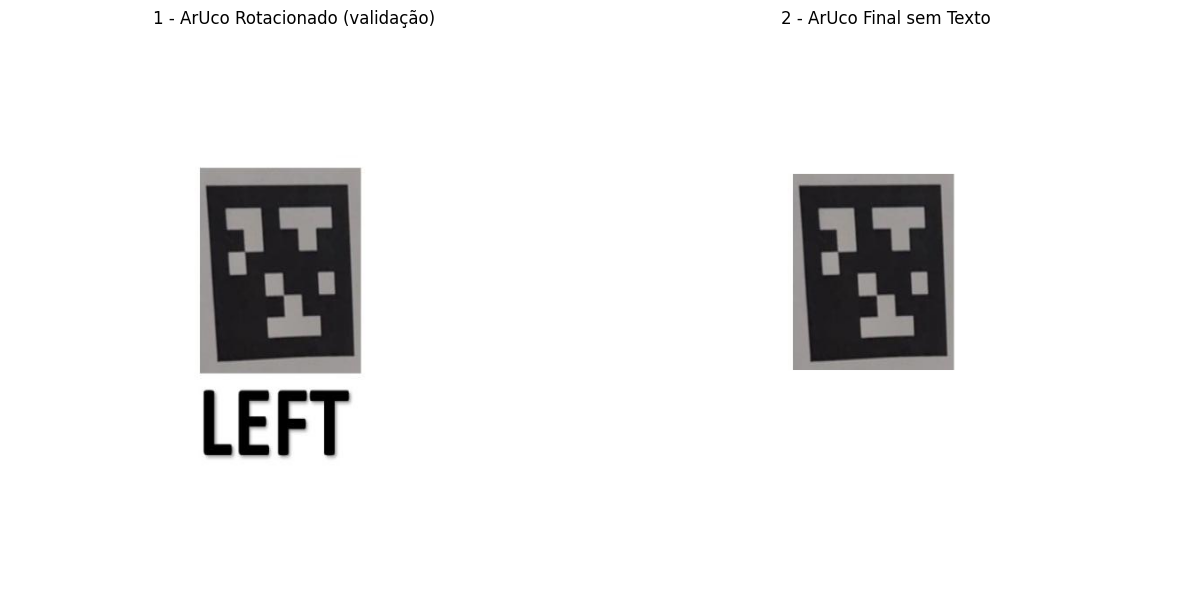

In [193]:
input_image = "Imagem4.jpg"

# Processar (sem gerar arquivos)
rotated, final = process_aruco_complete(
    input_image,
    debug=True
)

# Validação
if rotated is not None and final is not None:
    print()
    print("=" * 75)
    print("VALIDAÇÃO VISUAL:")
    print("✓ Texto ABAIXO do ArUco = CORRETO")
    print("✗ Texto ACIMA do ArUco = INCORRETO")
    print("✗ Texto À ESQUERDA/DIREITA = INCORRETO")
    print("=" * 75)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(rotated)
    plt.title("1 - ArUco Rotacionado (validação)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(final)
    plt.title("2 - ArUco Final sem Texto")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

PROCESSAMENTO DE IMAGEM

    Binariza a imagem em escala de cinza
    Pixels abaixo do threshold = 0 (preto)
    Pixels acima do threshold = 255 (branco)

In [194]:
def binarize_image(gray_array, threshold=127):
    binary = np.where(gray_array < threshold, 0, 255).astype(np.uint8)
    return binary

    Detecta bordas usando operador de Sobel
    Retorna magnitude e direção das bordas

In [195]:
def sobel_edge_detection(gray_array):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)

    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32)

    height, width = gray_array.shape
    grad_x = np.zeros_like(gray_array, dtype=np.float32)
    grad_y = np.zeros_like(gray_array, dtype=np.float32)

    padded = np.pad(gray_array, ((1, 1), (1, 1)), mode='edge')

    for i in range(height):
        for j in range(width):
            region = padded[i:i+3, j:j+3].astype(np.float32)
            grad_x[i, j] = np.sum(region * sobel_x)
            grad_y[i, j] = np.sum(region * sobel_y)

    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    magnitude = np.clip(magnitude, 0, 255).astype(np.uint8)

    direction = np.arctan2(grad_y, grad_x)

    return magnitude, direction

    Detecta especificamente as bordas da região PRETA (ArUco interno)
    Ignora a borda cinza externa

In [196]:
def detect_black_region_boundaries(gray_array, debug=False):
    height, width = gray_array.shape

    # Threshold mais agressivo: apenas pixels MUITO escuros (pretos)
    # Cinza típico: 100-180, Preto do ArUco: < 80
    black_threshold = 80
    black_mask = (gray_array < black_threshold).astype(np.uint8) * 255

    if debug:
        print(f"   Threshold para preto: {black_threshold}")
        print(f"   Pixels pretos detectados: {np.sum(black_mask == 255)}")

    # Detectar bordas APENAS na região preta
    edges, _ = sobel_edge_detection(black_mask)

    return edges, black_mask

TRANSFORMADA DE HOUGH

Transformada de Hough para detectar linhas retas
    Retorna as linhas encontradas em formato (rho, theta)

In [197]:
def hough_transform_lines(edge_image, threshold=50, debug=False):
    height, width = edge_image.shape

    # Diagonal máxima da imagem
    diagonal = int(np.sqrt(height**2 + width**2))

    # Espaço de Hough: rho x theta
    theta_res = 1
    rho_res = 1

    num_thetas = 180 // theta_res
    num_rhos = 2 * diagonal // rho_res

    # Acumulador de Hough
    accumulator = np.zeros((num_rhos, num_thetas), dtype=np.uint32)

    # Pré-calcular senos e cossenos
    thetas = np.deg2rad(np.arange(0, 180, theta_res))
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)

    # Encontrar pixels de borda
    edge_points = np.argwhere(edge_image > 100)

    if debug:
        print(f"   Pontos de borda encontrados: {len(edge_points)}")

    # Votar no espaço de Hough
    for y, x in edge_points:
        for theta_idx in range(num_thetas):
            rho = int(x * cos_thetas[theta_idx] + y * sin_thetas[theta_idx])
            rho_idx = rho + diagonal
            if 0 <= rho_idx < num_rhos:
                accumulator[rho_idx, theta_idx] += 1

    # Encontrar picos no acumulador
    lines = []
    acc_copy = accumulator.copy()

    for _ in range(20):
        max_val = np.max(acc_copy)
        if max_val < threshold:
            break

        max_idx = np.unravel_index(np.argmax(acc_copy), acc_copy.shape)
        rho_idx, theta_idx = max_idx

        rho = rho_idx - diagonal
        theta = thetas[theta_idx]

        lines.append((rho, theta, max_val))

        # Suprimir região ao redor do pico
        rho_min = max(0, rho_idx - 10)
        rho_max = min(num_rhos, rho_idx + 10)
        theta_min = max(0, theta_idx - 10)
        theta_max = min(num_thetas, theta_idx + 10)

        acc_copy[rho_min:rho_max, theta_min:theta_max] = 0

    if debug:
        print(f"   Linhas detectadas: {len(lines)}")

    return lines

    Filtra as 4 linhas principais que formam o quadrado do ArUco
    Busca por 2 linhas ~verticais e 2 linhas ~horizontais

In [198]:
def filter_main_lines(lines, image_shape, debug=False):
    height, width = image_shape

    horizontal_lines = []
    vertical_lines = []

    for rho, theta, votes in lines:
        theta_deg = np.rad2deg(theta)

        if theta_deg < 20 or theta_deg > 160:
            horizontal_lines.append((rho, theta, votes))

        elif 70 < theta_deg < 110:
            vertical_lines.append((rho, theta, votes))

    horizontal_lines.sort(key=lambda x: x[2], reverse=True)
    vertical_lines.sort(key=lambda x: x[2], reverse=True)

    h_lines = horizontal_lines[:2]
    v_lines = vertical_lines[:2]

    if debug:
        print(f"   Linhas horizontais: {len(h_lines)}")
        print(f"   Linhas verticais: {len(v_lines)}")

    return h_lines, v_lines

GEOMETRIA E CANTOS

Calcula a interseção entre duas linhas no formato (rho, theta)

In [199]:
def line_intersection(line1, line2):
    rho1, theta1 = line1[0], line1[1]
    rho2, theta2 = line2[0], line2[1]

    a1 = np.cos(theta1)
    b1 = np.sin(theta1)
    c1 = rho1

    a2 = np.cos(theta2)
    b2 = np.sin(theta2)
    c2 = rho2

    det = a1 * b2 - a2 * b1

    if abs(det) < 1e-6:
        return None

    x = (b2 * c1 - b1 * c2) / det
    y = (a1 * c2 - a2 * c1) / det

    return (int(x), int(y))

Encontra os 4 cantos do ArUco a partir das linhas detectadas

In [200]:
def find_aruco_corners(h_lines, v_lines, debug=False):
    if len(h_lines) < 2 or len(v_lines) < 2:
        if debug:
            print("   ✗ Não foi possível detectar 4 linhas principais")
        return None

    corners = []

    for h_line in h_lines:
        for v_line in v_lines:
            intersection = line_intersection(h_line, v_line)
            if intersection is not None:
                corners.append(intersection)

    if len(corners) < 4:
        if debug:
            print(f"   ✗ Apenas {len(corners)} cantos detectados")
        return None

    corners = np.array(corners)

    corners = corners[corners[:, 1].argsort()]

    top_corners = corners[:2]
    bottom_corners = corners[2:4]

    top_corners = top_corners[top_corners[:, 0].argsort()]
    bottom_corners = bottom_corners[bottom_corners[:, 0].argsort()]

    ordered_corners = np.vstack([
        top_corners[0],
        top_corners[1],
        bottom_corners[1],
        bottom_corners[0]
    ])

    if debug:
        print(f"   ✓ 4 cantos detectados:")
        print(f"     Top-Left: {ordered_corners[0]}")
        print(f"     Top-Right: {ordered_corners[1]}")
        print(f"     Bottom-Right: {ordered_corners[2]}")
        print(f"     Bottom-Left: {ordered_corners[3]}")

    return ordered_corners


VISUALIZAÇÃO

Desenha o resultado da detecção na imagem

In [201]:
def draw_detection_result(img_array, corners):
    result = img_array.copy()

    if corners is None or len(corners) != 4:
        return result

    # Garantir array inteiro
    corners = np.array(corners, dtype=int)

    # Desenhar linhas conectando os cantos
    for i in range(4):
        x1, y1 = corners[i]
        x2, y2 = corners[(i + 1) % 4]

        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx - dy

        x, y = x1, y1

        while True:
            if 0 <= x < result.shape[1] and 0 <= y < result.shape[0]:
                # Linha verde
                for dy_offset in [-1, 0, 1]:
                    for dx_offset in [-1, 0, 1]:
                        ny, nx = y + dy_offset, x + dx_offset
                        if 0 <= nx < result.shape[1] and 0 <= ny < result.shape[0]:
                            result[ny, nx] = [0, 255, 0]

            if x == x2 and y == y2:
                break

            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x += sx
            if e2 < dx:
                err += dx
                y += sy

    # Desenhar cantos (círculos vermelhos)
    for cx, cy in corners:
        radius = 5
        for dy in range(-radius, radius + 1):
            for dx in range(-radius, radius + 1):
                if dx*dx + dy*dy <= radius*radius:
                    ny, nx = cy + dy, cx + dx
                    if 0 <= nx < result.shape[1] and 0 <= ny < result.shape[0]:
                        result[ny, nx] = [255, 0, 0]

    return result


    Pipeline de detecção focado APENAS na região preta do ArUco
    Ignora a borda cinza

In [202]:
def detect_aruco_black_only(img_array, debug=True):
    if debug:
        print("=" * 75)
        print("DETECÇÃO DE ARUCO - Apenas Região PRETA")
        print("(Ignorando borda cinza)")
        print("=" * 75)
        print()

    # Garantir 3 canais
    if img_array.ndim == 2:
        img_array = np.stack([img_array]*3, axis=-1)
    elif img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]

    height, width = img_array.shape[:2]

    if debug:
        print("1. Imagem recebida em memória")
        print(f"   Dimensões: {width}x{height}px")
        print()

    # Converter para escala de cinza
    if debug:
        print("2. Convertendo para escala de cinza...")
    gray = np.dot(img_array[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)
    print()

    # Detectar apenas região preta
    if debug:
        print("3. Detectando região PRETA (threshold < 80)...")
    edges, black_mask = detect_black_region_boundaries(gray, debug=debug)
    print()

    # Transformada de Hough
    if debug:
        print("4. Aplicando Transformada de Hough...")
    lines = hough_transform_lines(edges, threshold=20, debug=debug)
    print()

    # Filtrar linhas
    if debug:
        print("5. Filtrando linhas principais...")
    h_lines, v_lines = filter_main_lines(lines, (height, width), debug=debug)
    print()

    # Encontrar cantos
    if debug:
        print("6. Calculando interseções (cantos do ArUco)...")
    corners = find_aruco_corners(h_lines, v_lines, debug=debug)
    print()

    if debug:
        print("=" * 75)
        if corners is not None:
            print("✓ DETECÇÃO CONCLUÍDA - ArUco PRETO localizado!")
        else:
            print("✗ FALHA NA DETECÇÃO")
        print("=" * 75)

    return corners, edges, black_mask


Execução

DETECÇÃO DE ARUCO - Apenas Região PRETA
(Ignorando borda cinza)

1. Imagem recebida em memória
   Dimensões: 640x640px

2. Convertendo para escala de cinza...

3. Detectando região PRETA (threshold < 80)...
   Threshold para preto: 80
   Pixels pretos detectados: 23614

4. Aplicando Transformada de Hough...
   Pontos de borda encontrados: 3295
   Linhas detectadas: 20

5. Filtrando linhas principais...
   Linhas horizontais: 2
   Linhas verticais: 2

6. Calculando interseções (cantos do ArUco)...
   ✓ 4 cantos detectados:
     Top-Left: [219 173]
     Top-Right: [380 172]
     Bottom-Right: [386 363]
     Bottom-Left: [233 371]

✓ DETECÇÃO CONCLUÍDA - ArUco PRETO localizado!

DETECÇÃO DO ArUco (REGIÃO PRETA)
Número de cantos detectados: 4


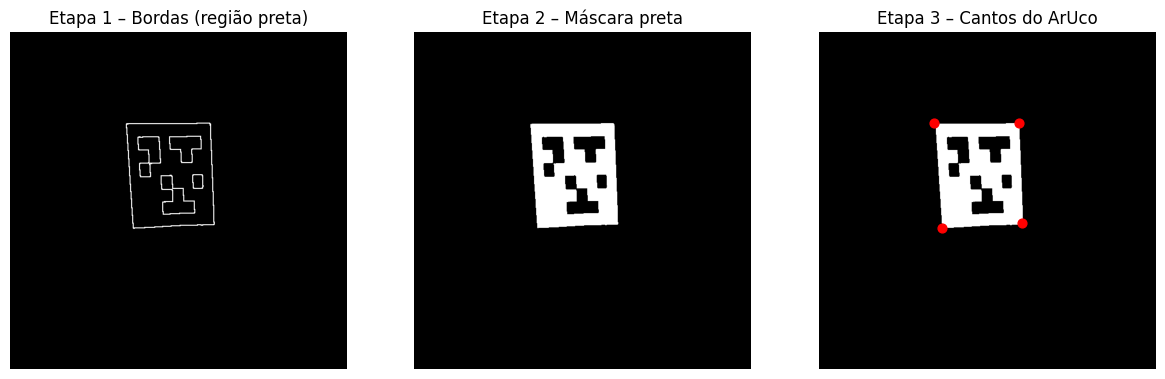

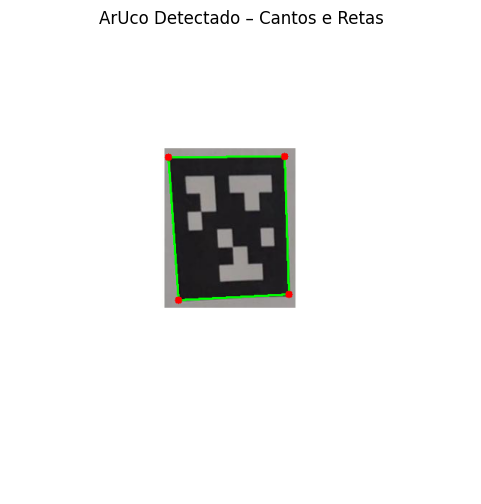

<Figure size 640x480 with 0 Axes>

In [203]:
# Verificação de segurança
if final is None:
    raise ValueError("A variável 'final' não existe. Execute a célula anterior primeiro.")

# Executar detecção usando a imagem FINAL em memória
corners, edges, black_mask = detect_aruco_black_only(
    final,
    debug=True
)

# Validação
if corners is not None:
    print()
    print("=" * 75)
    print("DETECÇÃO DO ArUco (REGIÃO PRETA)")
    print(f"Número de cantos detectados: {len(corners)}")
    print("=" * 75)

    plt.figure(figsize=(20, 5))

    # Etapa 1 – Bordas
    plt.subplot(1, 4, 1)
    plt.imshow(edges, cmap="gray")
    plt.title("Etapa 1 – Bordas (região preta)")
    plt.axis("off")

    # Etapa 2 – Máscara preta
    plt.subplot(1, 4, 2)
    plt.imshow(black_mask, cmap="gray")
    plt.title("Etapa 2 – Máscara preta")
    plt.axis("off")

    # Etapa 3 – Cantos detectados sobre a máscara
    plt.subplot(1, 4, 3)
    plt.imshow(black_mask, cmap="gray")
    plt.scatter(corners[:, 0], corners[:, 1], c="red", s=40)
    plt.title("Etapa 3 – Cantos do ArUco")
    plt.axis("off")

    # Etapa 4 – ArUco detectado (equivalente ao aruco_detectado_preto.png)
    resultado_final = draw_detection_result(final, corners)

    plt.figure(figsize=(6, 6))
    plt.imshow(resultado_final)
    plt.title("ArUco Detectado – Cantos e Retas")
    plt.axis("off")
    plt.show()
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum ArUco foi detectado.")